In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html(index=False).replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Customer Insights Analytics, Pareto and Recency, Frequency and Monetary Value Analysis/Segmentation:

In [2]:
!ls

Customers Insights & RFM Analysis.png customer_insights.ipynb
README.md                             e-commerce_data.csv


## 1. Cleaning, Exploration and Visualisation:

In [3]:
df = pd.read_csv('e-commerce_data.csv',encoding = "ISO-8859-1")
print('rows:',df.shape[0],'columns:',df.shape[1])

df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df['CustomerID'] = df['CustomerID'].fillna(0).astype(int).astype(str).replace('0',np.nan)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['day'] = df['InvoiceDate'].dt.day
df['day_name'] = df['InvoiceDate'].dt.day_name() 
df['day_of_year'] = df['InvoiceDate'].dt.dayofyear 
df['week'] = df['InvoiceDate'].dt.weekofyear 
df['hour'] = df['InvoiceDate'].dt.hour  
df['month'] = df['InvoiceDate'].dt.month
df['year'] = df['InvoiceDate'].dt.year
df['weekday'] = df['InvoiceDate'].dt.dayofweek
df['weekend'] = [0 if x <= 5 else 1 for x in df['weekday']]

df['month_year'] = df['year'].map(str)+ '-' +df['month'].map(str)
df['month_year'] = pd.to_datetime(df['month_year'], format='%Y-%m').dt.strftime('%Y-%m')

df.head(3)

rows: 541909 columns: 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,day,day_name,day_of_year,week,hour,month,year,weekday,weekend,month_year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,Wednesday,335,48,8,12,2010,2,0,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,Wednesday,335,48,8,12,2010,2,0,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1,Wednesday,335,48,8,12,2010,2,0,2010-12


In [4]:
def resume_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values 
    summary['Missing_%'] = np.round(df.isnull().sum().values / len(df) *100,2)
    summary['Uniques'] = df.nunique().values
    summary['Negative_value'] = [(df[x].values < 0).any() if df[x].dtype.name not in ['object','category','datetime64[ns]'] else False for x in df.columns]
    summary['First 5 Unique Values'] = [x for x in pd.Series({c: df[c].unique()[:5] for c in df})]
    
    ## Entropy is the measures of impurity, disorder or uncertainty.
    ## Entropy controls how a Decision Tree decides to split the data. It actually effects how a Decision Tree draws its boundaries.
    ## An attribute with highest Information gain will tested/split first.
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def highlight_mins(s):
    is_min = s > 0
    return ['background-color: red' if v else '' for v in is_min]

def negative(s):
    is_neg = s == True
    return ['background-color: orange' if v else '' for v in is_neg]

df_resume = resume_table(df)

df_resume.fillna(np.nan).style.apply(highlight_mins, subset=pd.IndexSlice[:, ['Missing']])\
                        .apply(negative, subset=pd.IndexSlice[:, ['Negative_value']])

# df_resume = resume_table(df)
# df_resume

Dataset Shape: (541909, 19)


,Name,dtypes,Missing,Missing_%,Uniques,Negative_value,First 5 Unique Values,Entropy
0,InvoiceNo,object,0,0.000000,25900,False,['536365' '536366' '536367' '536368' '536369'],13.390000
1,StockCode,object,0,0.000000,4070,False,['85123A' '71053' '84406B' '84029G' '84029E'],10.910000
2,Description,object,1454,0.270000,4223,False,['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN' 'CREAM CUPID HEARTS COAT HANGER' 'KNITTED UNION FLAG HOT WATER BOTTLE' 'RED WOOLLY HOTTIE WHITE HEART.'],10.930000
3,Quantity,int64,0,0.000000,722,True,[ 6 8 2 32 3],3.720000
4,InvoiceDate,datetime64[ns],0,0.000000,23260,False,['2010-12-01T08:26:00.000000000' '2010-12-01T08:28:00.000000000' '2010-12-01T08:34:00.000000000' '2010-12-01T08:35:00.000000000' '2010-12-01T08:45:00.000000000'],13.280000
5,UnitPrice,float64,0,0.000000,1630,True,[2.55 3.39 2.75 7.65 4.25],5.680000
6,CustomerID,object,135080,24.930000,4372,False,['17850' '13047' '12583' '13748' '15100'],10.850000
7,Country,object,0,0.000000,38,False,['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany'],0.740000
8,TotalPrice,float64,0,0.000000,6204,True,[15.3 20.34 22. 15.3 25.5 ],8.380000
9,day,int64,0,0.000000,31,False,[1 2 3 5 6],4.920000


In [5]:
# def highlight_mins(s):
#     is_min = s < s.max()
#     return ['background-color: red' if v else '' for v in is_min]

# def negative(s):
#     is_neg = s < 0
#     return ['background-color: orange' if v else '' for v in is_neg]

In [6]:
# df_desc = df.describe(include='all').T.drop(['top','first','last'],axis=1)

# df_desc.fillna(np.nan).style.apply(highlight_mins, subset=pd.IndexSlice[:, ['count']])\
#                         .apply(negative, subset=pd.IndexSlice[:, ['min']])

### Columns 'Description' and 'CustomerID' have missing values:

- 'Description' feature not only have empty descriptions but also incorrect ones (same stockcode with different descriptions), so instead of just dropping them we will map them back based on their relation 'StockCode' to 'Description'.

- 'CustomerID' feature has 3710 invoice with no CustomerID which represents 135 thousand lines, I will not filter them out but give them new and individual CustomerIDs assuming they are seperate customers. If we had better data we could surely do something better.

#### Treatment of the 'Description' column:

In [7]:
# ## checking the 'Description' column:
# df[(df['StockCode'] == '22139')].head(50)

In [8]:
df['StockCode'] = df['StockCode'].str.upper()

## description that comes back the most per 'StockCode'. if a list comes back, choose first element.
stockCode = df.groupby(['StockCode'])['Description'].agg(lambda x: x.mode(dropna=False).iloc[0]).to_frame().rename(columns={'Description':'Description2'}) #.agg(pd.Series.mode).rename('Description2')

print('Empty descriptions before fix:',len(df[df['Description'].isnull()]))
df = df.merge(stockCode,how='left',left_on='StockCode',right_on='StockCode').drop('Description',axis=1).rename(columns={'Description2':'Description'})
df['Description'] = df['Description'].astype(str).apply(lambda x: np.nan if len(x)==0 else x)
print('Empty descriptions after fix:',len(df[df['Description'].isnull()]))
df.head(3)

Empty descriptions before fix: 1454
Empty descriptions after fix: 0


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,day,day_name,day_of_year,week,hour,month,year,weekday,weekend,month_year,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,Wednesday,335,48,8,12,2010,2,0,2010-12,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,Wednesday,335,48,8,12,2010,2,0,2010-12,WHITE METAL LANTERN
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1,Wednesday,335,48,8,12,2010,2,0,2010-12,CREAM CUPID HEARTS COAT HANGER


#### Treatment of the 'CustomerID' column:

In [9]:
print("Number of invoices with no CustomerID",len(df[(df['CustomerID'].isnull())]['InvoiceNo'].unique()))

Number of invoices with no CustomerID 3710


In [10]:
listy = df[(df['CustomerID'].isnull())]['InvoiceNo'].unique()

dicco_unknown_customer = {}
for i in range(len(listy)):
    dicco_unknown_customer[listy[i]] = 'cust_{}'.format(i)

print('Empty CustomerID before fix:',len(df[df['CustomerID'].isnull()]))
df['CustomerID'] = [x if x is not np.nan else dicco_unknown_customer[y] for x,y in zip(df['CustomerID'],df['InvoiceNo'])] 
print('Empty CustomerID before fix:',len(df[df['CustomerID'].isnull()]))

Empty CustomerID before fix: 135080
Empty CustomerID before fix: 0


### Let's visualise our dataset:

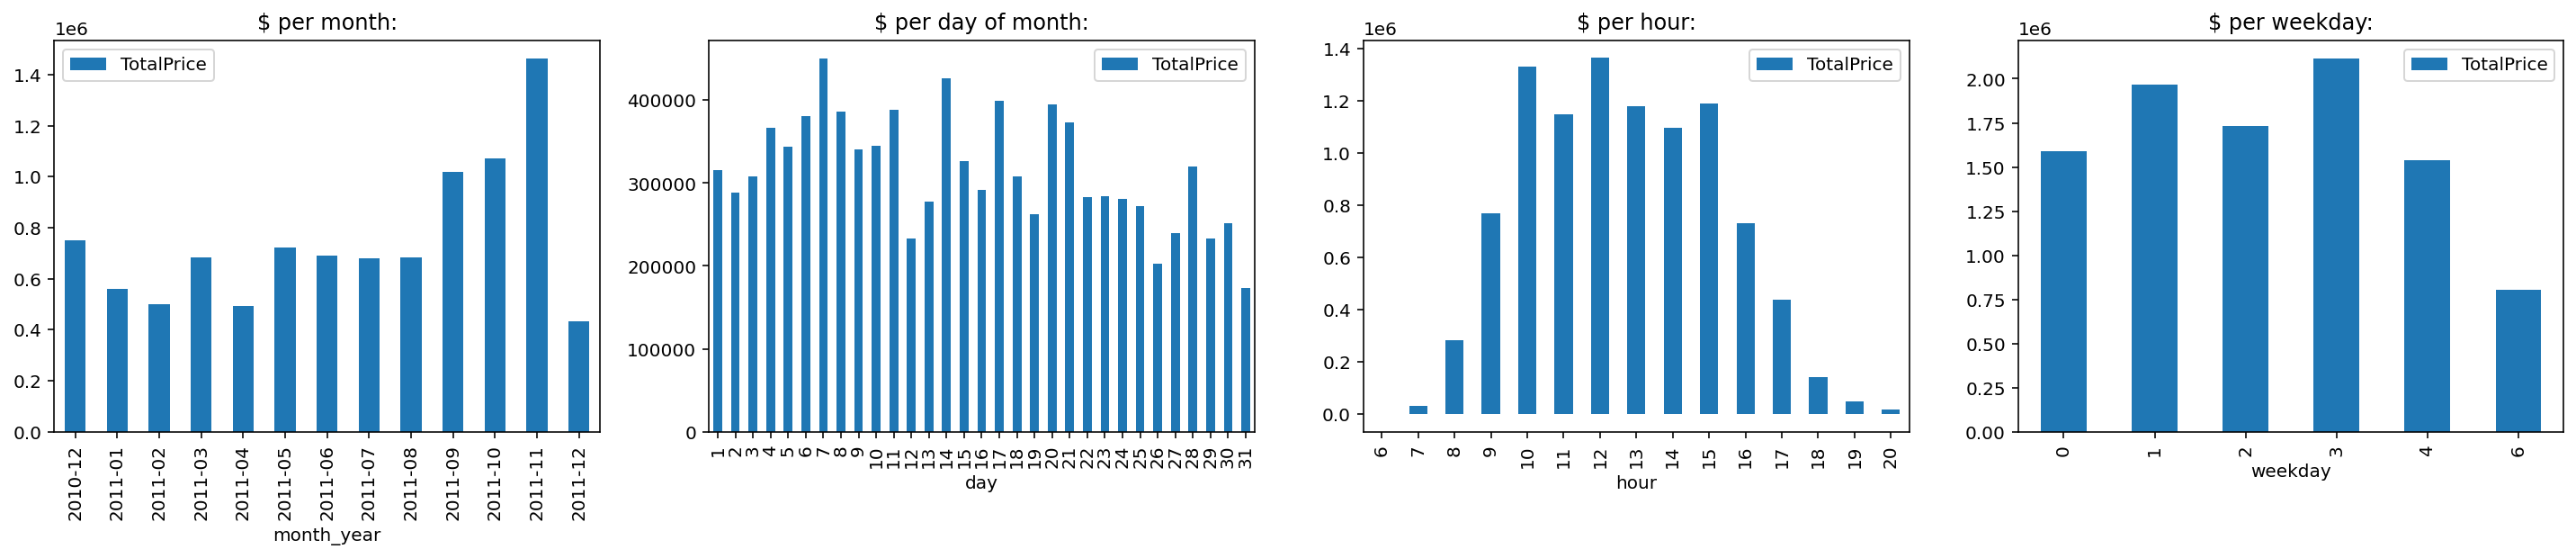

In [11]:
fig,ax=plt.subplots(1,4,figsize=(25,4))

df.groupby(["month_year"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[0]);
ax[0].set_title('$ per month:');

df.groupby(["day"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[1]);
ax[1].set_title('$ per day of month:');

df.groupby(["hour"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[2]);
ax[2].set_title('$ per hour:');

df.groupby(["weekday"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[3]);
ax[3].set_title('$ per weekday:');

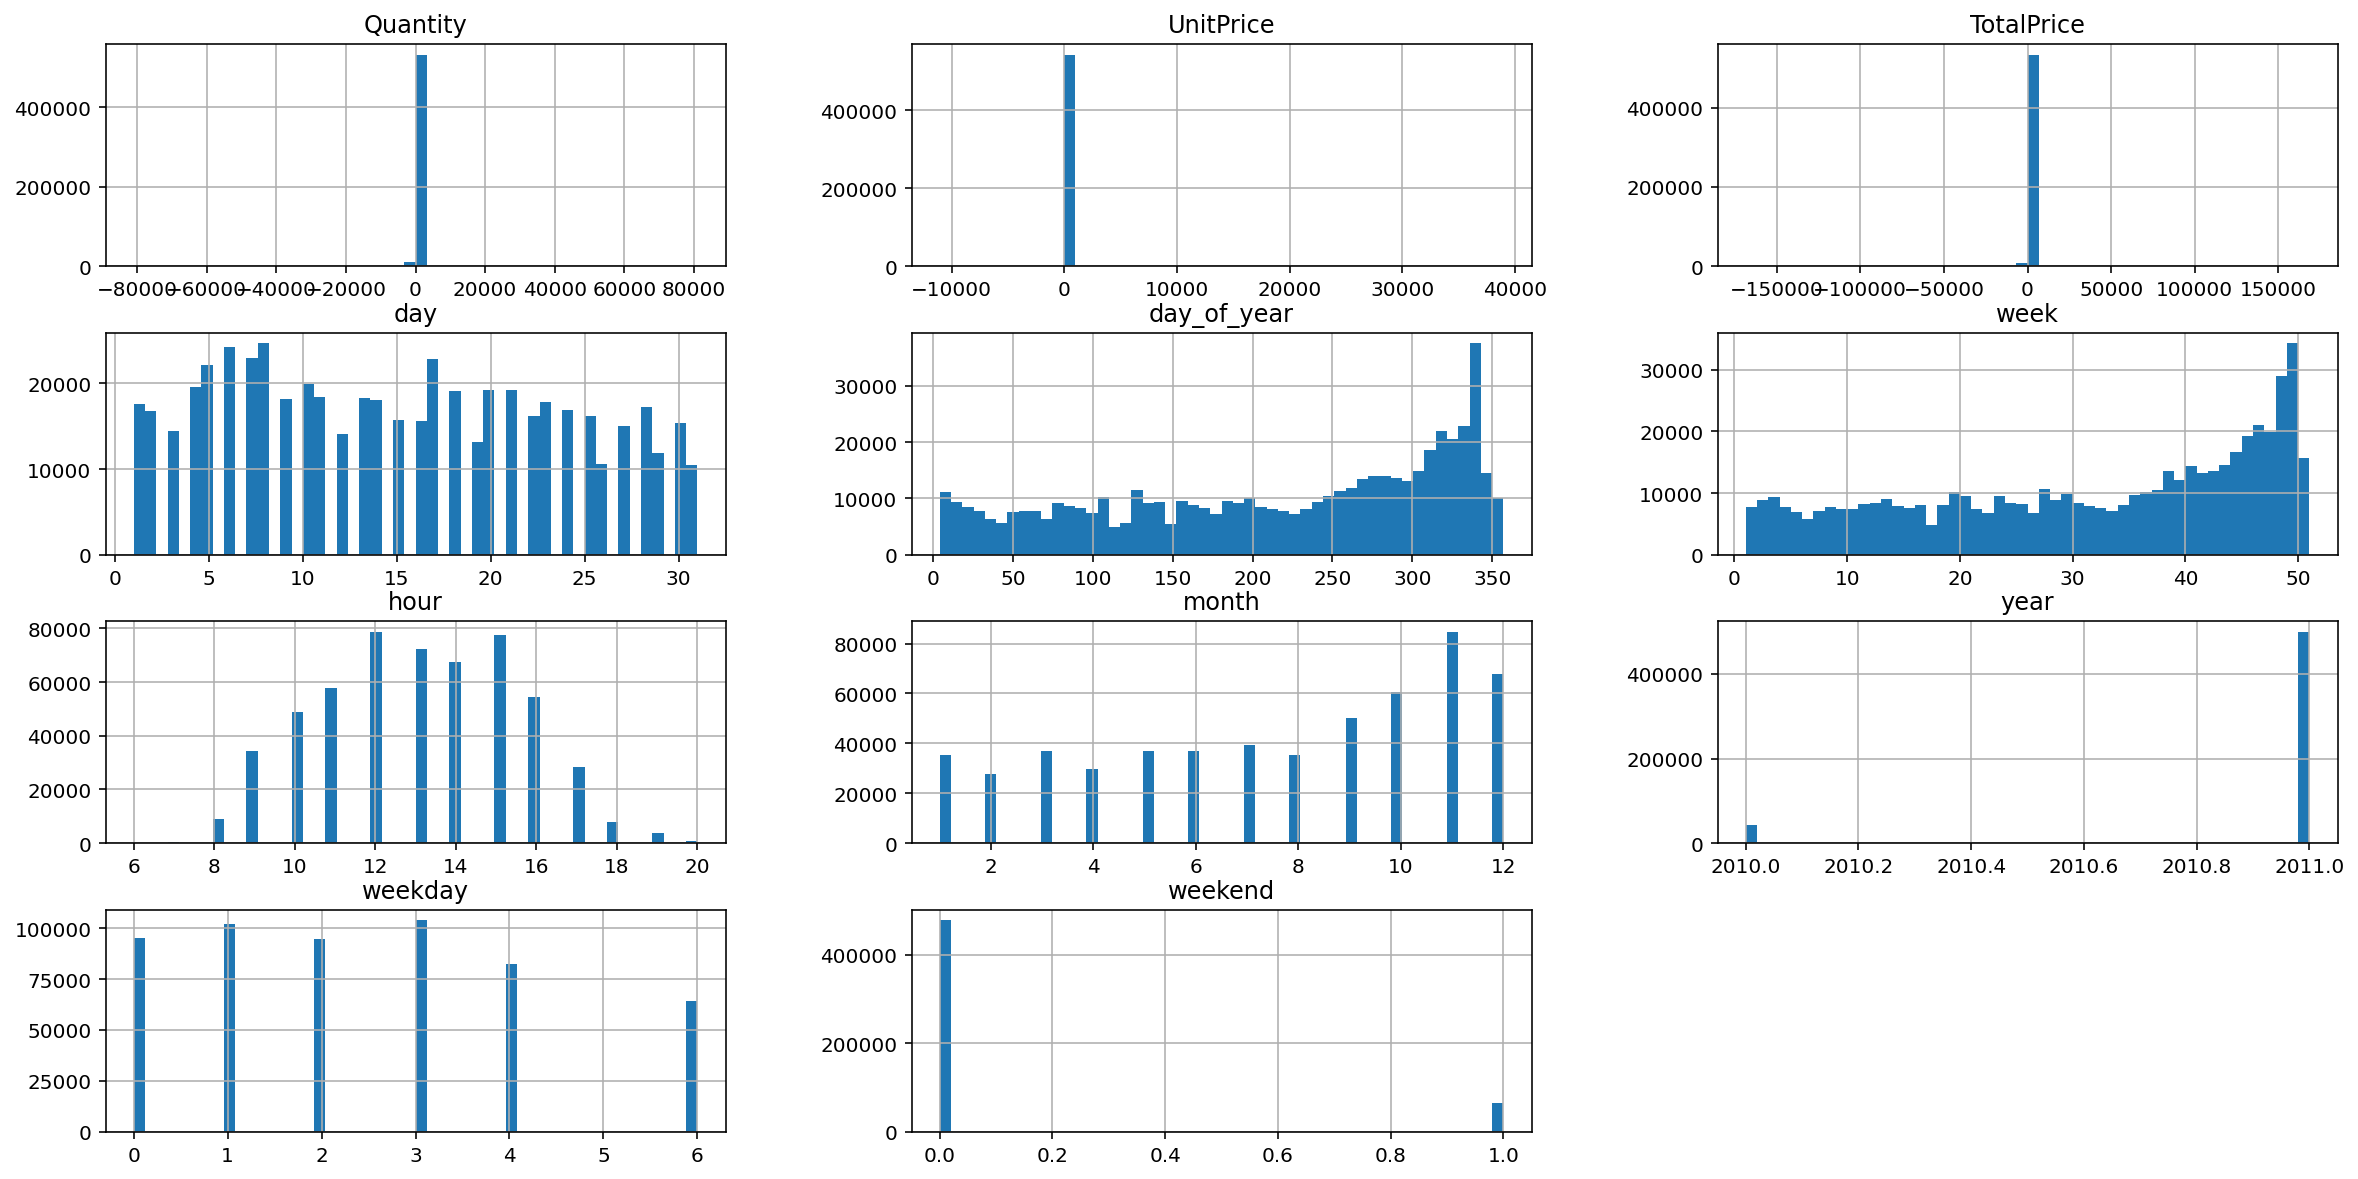

In [12]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df.hist(bins=50, ax=ax);

### Let's look at the log distribution for 'Quantity','UnitPrice','TotalPrice' as it isn't clear above:

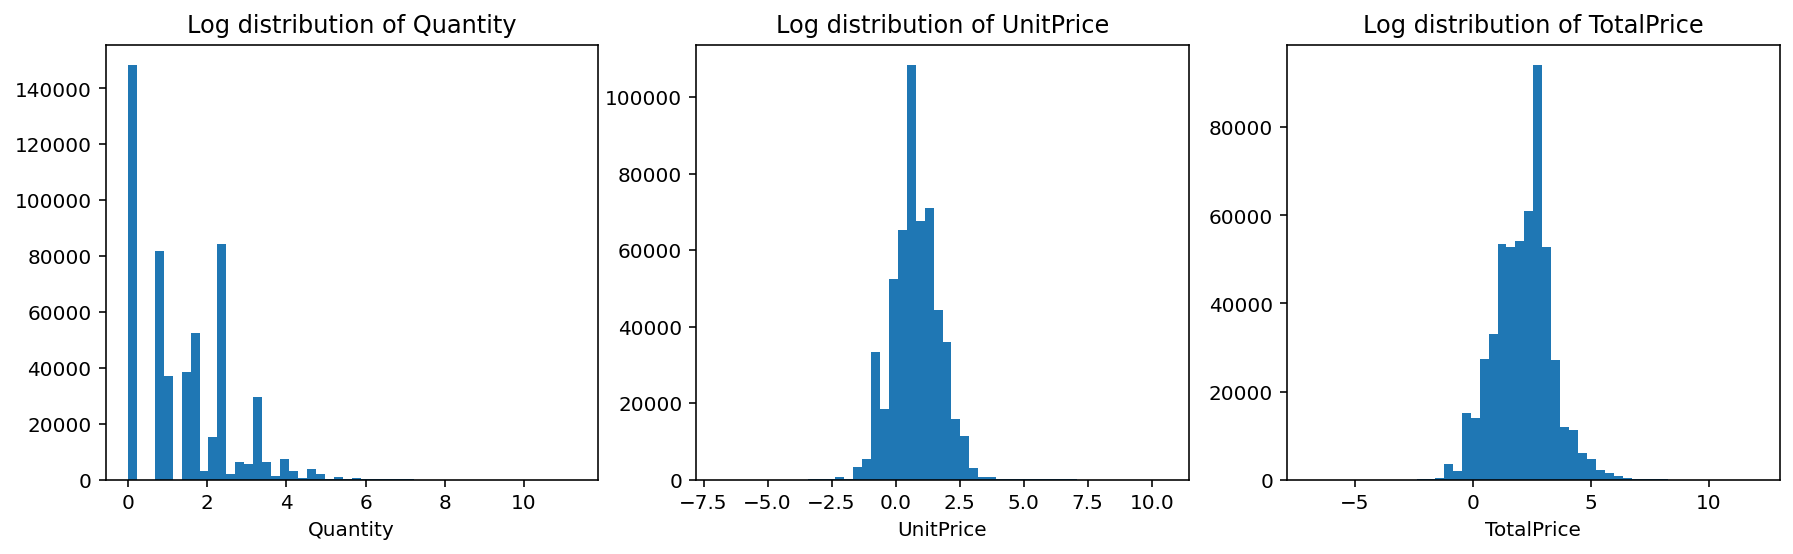

In [13]:
fig,ax=plt.subplots(1,3,figsize=(15,4))

listy = ['Quantity','UnitPrice','TotalPrice']

for i in range(len(listy)):
        df1 = pd.DataFrame()
        df1['log_{}'.format(listy[i])] = np.log(df[listy[i]])
        ax[i].hist(df1[np.isfinite(df1['log_{}'.format(listy[i])])]['log_{}'.format(listy[i])].values,bins=50)
        ax[i].set_xlabel(listy[i])
        ax[i].set_title('Log distribution of {}'.format(listy[i]))

### Pareto chart and 80-20 rule:

#### The 80/20 rule states that for many events roughly 80% of the effects come from 20% of the causes.

Let's check here if 80% of revenue are generated by 20% of our customers:

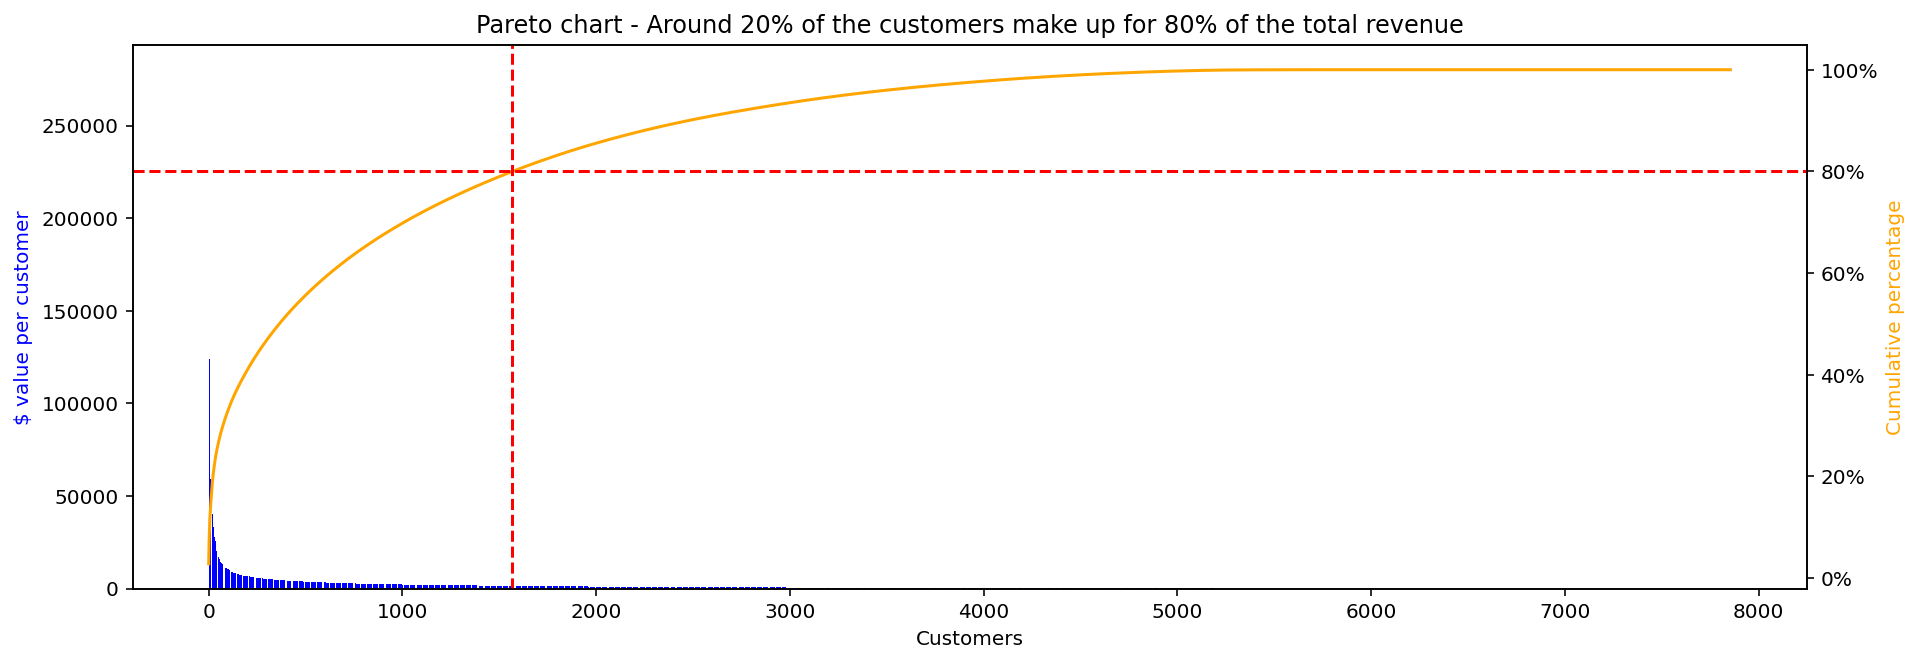

In [14]:
desc_price = df.groupby(['CustomerID']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False)
desc_price = desc_price[desc_price['TotalPrice'] >= 0]
desc_price['cumulative_sum'] = desc_price['TotalPrice'].cumsum()
desc_price['cumulative_pct'] = desc_price['cumulative_sum']/desc_price['TotalPrice'].sum()*100
desc_price = desc_price.reset_index(drop=True)


value_closest_to_80 = desc_price.iloc[(desc_price['cumulative_pct']-80).abs().argsort()[:1]].index[0]

import matplotlib.ticker as mtick

fig,ax=plt.subplots(figsize=(15,5))

ax.set_title('Pareto chart - Around {}% of the customers make up for 80% of the total revenue'.format(round(value_closest_to_80/len(desc_price)*100)))

ax2 = ax.twinx()

ax.bar(desc_price.index,desc_price['TotalPrice'],color='blue');
ax.set_xlabel('Customers')
ax.set_ylabel('$ value per customer',color='blue')

ax2.plot(desc_price.index,desc_price['cumulative_pct'],color='orange');
ax2.set_ylabel('Cumulative percentage',color='orange')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.axhline(y=80, color='r', linestyle='--');
ax2.axvline(x=value_closest_to_80, color='r', linestyle='--');

### Top 5 Items ordered (dollar value wise) and their trend, what can you deduce from this?

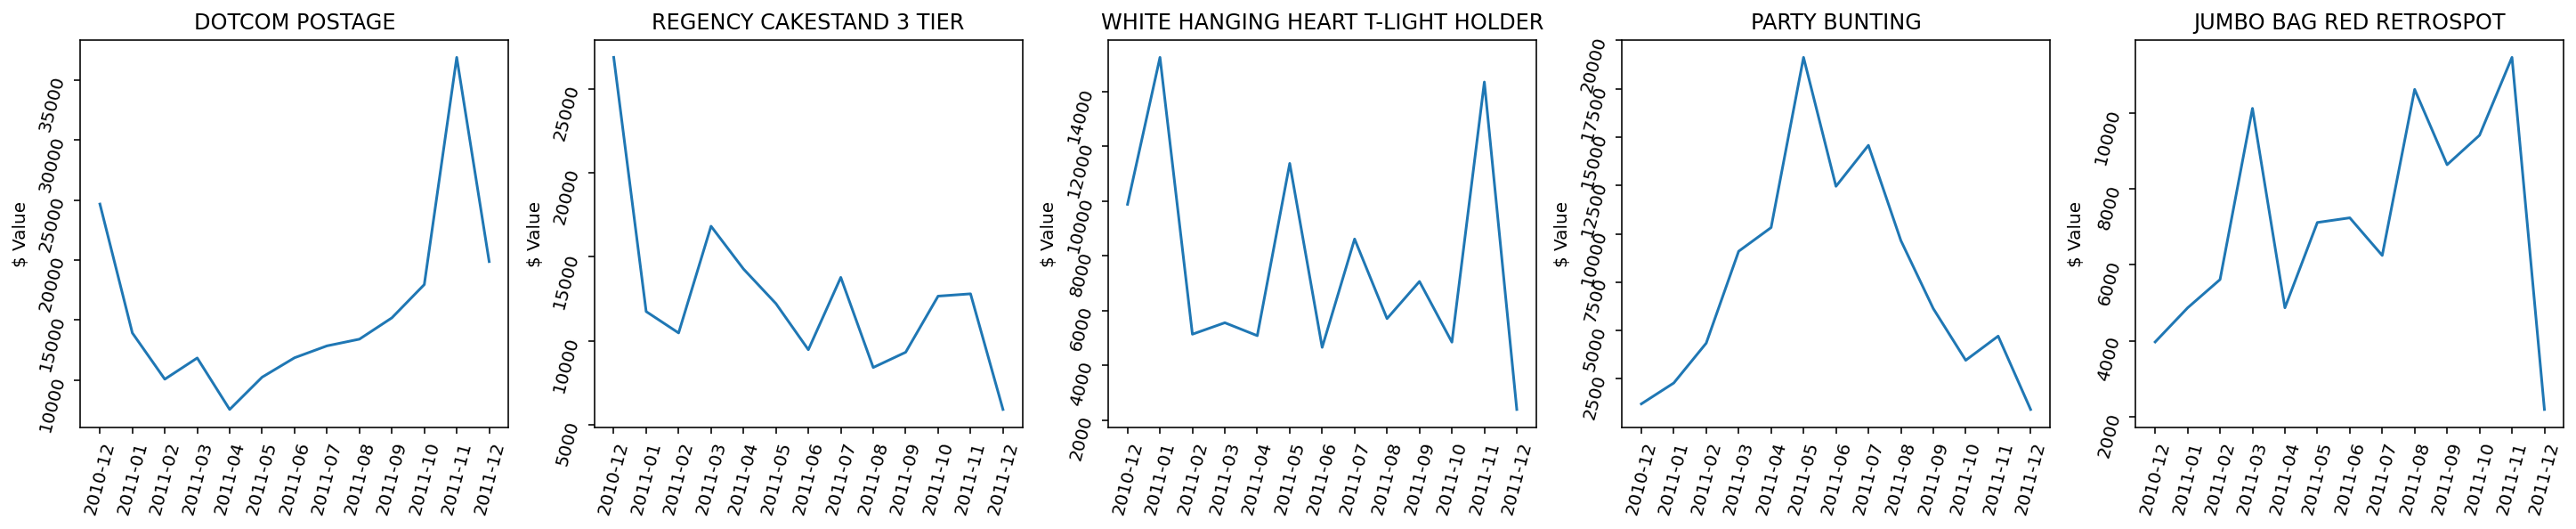

In [15]:
description = df.groupby(['Description']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False).head(5)

dfT = df[df['Description'].isin(description['Description'].unique())]
dfT = dfT.groupby(['month_year','Description']).agg({'TotalPrice':np.sum}).reset_index()

listo = description['Description'].unique()

fig,ax=plt.subplots(1,len(listo),figsize=(25,4))

for i in range(len(listo)):
    dfW = dfT[dfT['Description'] == listo[i]]
    ax[i].plot(dfW['month_year'],dfW['TotalPrice'],label=listo[i])
    ax[i].tick_params(labelrotation=75)
    ax[i].set_ylabel('$ Value')
    ax[i].set_title(listo[i])

In [16]:
country = df.groupby(['Country']).agg({'CustomerID':pd.Series.nunique}).reset_index().sort_values('CustomerID',ascending=False)

desc_quant = df.groupby(['Description']).agg({'CustomerID':pd.Series.nunique}).reset_index().sort_values('CustomerID',ascending=False)

desc_price = df.groupby(['Description']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False)

invoice = df.groupby(['CustomerID']).agg({'InvoiceNo':pd.Series.nunique}).reset_index().sort_values('InvoiceNo',ascending=False).rename(columns={'InvoiceNo':'NumInvoice'})

quantity = df.groupby(['CustomerID']).agg({'Quantity':np.sum}).reset_index().sort_values('Quantity',ascending=False).rename(columns={'Quantity':'TotalQuantity'})

amount = df.groupby(['CustomerID']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False)


display_side_by_side(country.head(), desc_quant.head(),desc_price.head(),invoice.head(),quantity.head(),amount.head(),
                     titles=['Top 5 Country with most Customers','Top 5 items ordered the most','Top 5 categories $ value wise','Top 5 Customers with most invoices',
                             'Top 5 Customers with most quantities','Top 5 Customers with most $value spent'])

Country,CustomerID
United Kingdom,7587
Germany,95
France,90
EIRE,44
Spain,31
Description,CustomerID
REGENCY CAKESTAND 3 TIER,1175
WHITE HANGING HEART T-LIGHT HOLDER,1151
JUMBO BAG RED RETROSPOT,1128
PARTY BUNTING,1015


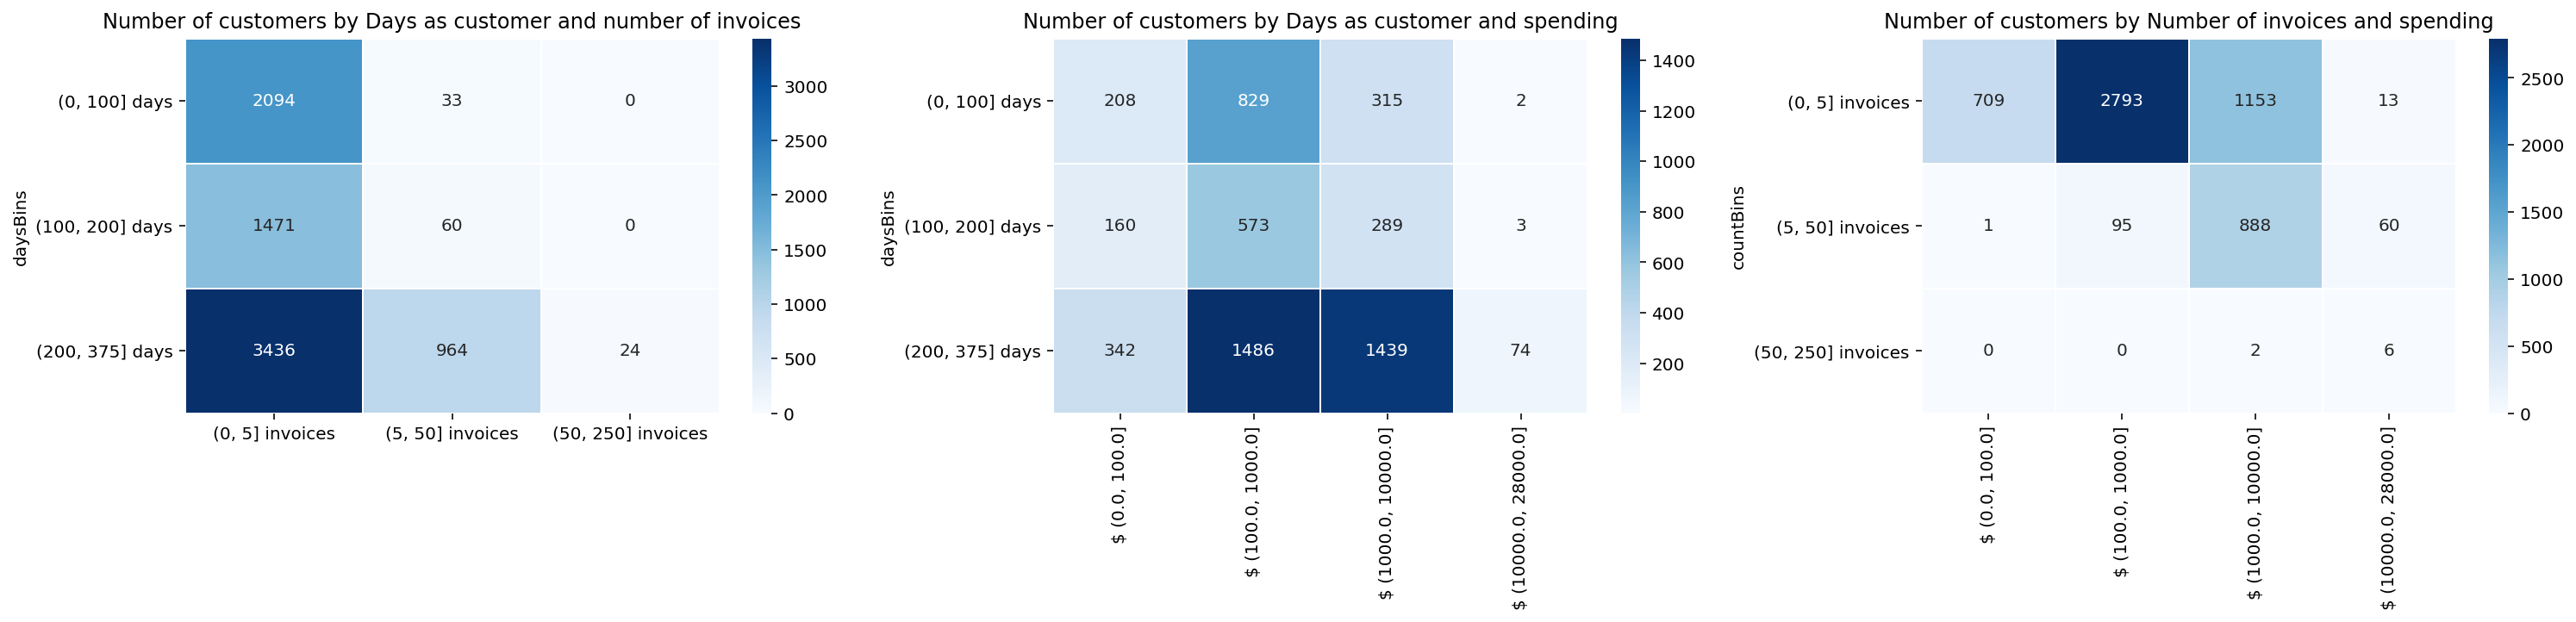

In [17]:
##### COUNT INVOICES #####
df3 = df.groupby(['CustomerID']).agg({'InvoiceDate':[min,pd.Series.nunique]}).reset_index()
df3.columns = ['CustomerID', 'FirstInvoice','CountInvoice']
df3['now'] = df['InvoiceDate'].max()
df3['days_as_customer'] = 1 + (df3['now']-df3['FirstInvoice']).astype('timedelta64[D]')
df3 = df3.drop(['now','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)
 
bins = [0, 5, 50, 250]
df3['countBins'] = pd.cut(df3['CountInvoice'], bins).astype(str) + " invoices"

bins = [0, 100, 200, 375]
df3['daysBins'] = pd.cut(df3['days_as_customer'], bins).astype(str) + " days"

df3 = pd.DataFrame(df3.pivot_table(index='daysBins',columns='countBins',values='CustomerID',aggfunc=pd.Series.nunique).to_records()).fillna(0)
#########################

##### $ VALUE #####
df6 = df.groupby(['CustomerID']).agg({'InvoiceDate':min,'TotalPrice':np.sum}).reset_index()
df6.columns = ['CustomerID', 'FirstInvoice','TotalAmount']
df6['now'] = df['InvoiceDate'].max()
df6['days_as_customer'] = 1 + (df6['now']-df6['FirstInvoice']).astype('timedelta64[D]')
df6 = df6.drop(['now','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)
 
bins = [0, 100, 1000, 10000, 28000]
df6['amountBins'] = '$ ' + pd.cut(df6['TotalAmount'], bins).astype(str)
df6 = df6[df6['amountBins'] != '$ nan']

bins = [0, 100, 200, 375]
df6['daysBins'] = pd.cut(df6['days_as_customer'], bins).astype(str) + " days"

df6 = pd.DataFrame(df6.pivot_table(index='daysBins',columns='amountBins',values='CustomerID',aggfunc=pd.Series.nunique).to_records()).fillna(0)
#########################


##### COUNT INVOICES & AMOUNT #####
df7 = df.groupby(['CustomerID']).agg({'InvoiceDate':[min,pd.Series.nunique],'TotalPrice':np.sum}).reset_index()
df7.columns = ['CustomerID', 'FirstInvoice','CountInvoice','TotalAmount']
df7['now'] = df['InvoiceDate'].max()
df7['days_as_customer'] = 1 + (df7['now']-df7['FirstInvoice']).astype('timedelta64[D]')
df7 = df7.drop(['now','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)
 
bins = [0, 5, 50, 250]
df7['countBins'] = pd.cut(df7['CountInvoice'], bins).astype(str) + " invoices"

bins = [0, 100, 200, 375]
df7['daysBins'] = pd.cut(df7['days_as_customer'], bins).astype(str) + " days"

bins = [0, 100, 1000, 10000, 28000]
df7['amountBins'] = "$ " + pd.cut(df7['TotalAmount'], bins).astype(str)
df7 = df7[df7['amountBins'] != '$ nan']

# 'daysBins',
df7 = pd.DataFrame(df7.pivot_table(index='countBins',columns='amountBins',values='CustomerID',aggfunc=pd.Series.nunique).to_records()).fillna(0)

##################################

# display_side_by_side(df3,df6,df7,titles=['Count of invoices per Customers','Value spent per Customers','Count of invoices and value spent per Customers'])


fig,ax=plt.subplots(1,3,figsize=(25,4))
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.subplots_adjust(wspace = 0.3)

df3 = df3.set_index('daysBins')
sns.heatmap(df3, cmap='Blues', linewidths=0.5, annot=True,fmt='g',ax=ax[0]); #cmap='RdYlGn_r'
ax[0].set_title('Number of customers by Days as customer and number of invoices');

df6 = df6.set_index('daysBins')
sns.heatmap(df6, cmap='Blues', linewidths=0.5, annot=True,fmt='g',ax=ax[1]);
ax[1].set_title('Number of customers by Days as customer and spending');

df7 = df7.set_index('countBins')
sns.heatmap(df7, cmap='Blues', linewidths=0.5, annot=True,fmt='g',ax=ax[2]);
ax[2].set_title('Number of customers by Number of invoices and spending');

**First heatmap:**
- the majority of customers (new or long term) have 5 or less invoices. 

**Second heatmap:**
- the majority of customer spent 100 to 1000 dollars with approx a quarter that spent 1000 to 10,000 dollars.

**Third heatmap:**
- the majority of customers with 5 or less invoices spend 100 to 10,000 dollars.
- the majority of customers with 5 to 50 invoices and all customers with 50 to 250 invoices spent 1,000 to 28,000 dollars.

### Could we predict their next purchase date?

CustomerID,FirstInvoice,LastInvoice,NumInvoice,TotalSales,DaysBetweenFirstLastInv,lastDate,days_as_customer,days_since_purchase,AvgDaysBetweenPurchases,NextPurchaseInDays
13173,2010-12-07 14:30:00,2011-12-05 15:51:00,2,353.65,363.0,2011-12-09 12:50:00,366.0,3.0,363.0,360.0
12785,2010-12-10 13:48:00,2011-12-07 12:46:00,2,305.71,361.0,2011-12-09 12:50:00,363.0,2.0,361.0,359.0
14594,2010-12-01 13:54:00,2011-12-02 13:28:00,2,379.83,365.0,2011-12-09 12:50:00,372.0,6.0,365.0,359.0
14865,2010-12-02 18:23:00,2011-12-02 16:25:00,2,52.20,364.0,2011-12-09 12:50:00,371.0,6.0,364.0,358.0
15822,2010-12-15 13:38:00,2011-12-06 14:50:00,2,885.47,356.0,2011-12-09 12:50:00,358.0,2.0,356.0,354.0


Distribution of the number of:
- Days Between First and Last Invoice
- Days as Customer
- Days Since last Purchase
- Average Days Between Purchases
- Next Purchase In Days (neg: overdue in days, pos: due in x days)


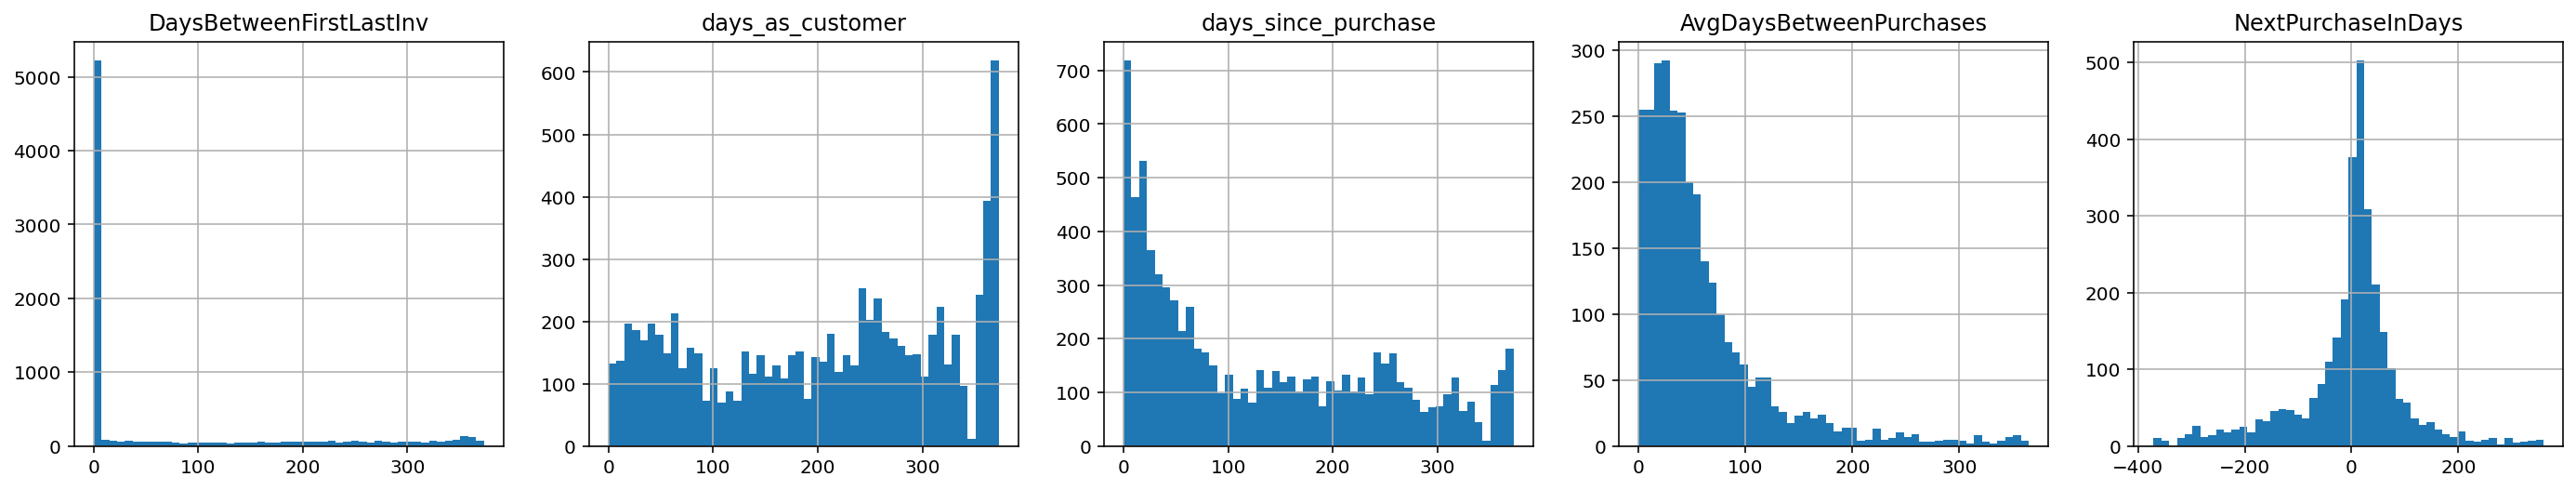

In [18]:
df1 = df.groupby(['CustomerID']).agg({'InvoiceDate':[min,max],'InvoiceNo':pd.Series.nunique,'TotalPrice':np.sum}).reset_index()
df1.columns = [' '.join(col).strip() for col in df1.columns.values]
df1 = df1.rename(columns={'InvoiceDate min':'FirstInvoice','InvoiceDate max':'LastInvoice','InvoiceNo nunique':'NumInvoice','TotalPrice sum':'TotalSales'})
## DaysBetweenFirstLastInv
df1['DaysBetweenFirstLastInv'] = (df1['LastInvoice']-df1['FirstInvoice']).astype('timedelta64[D]') # 1 +
## days_as_customer
df1['lastDate'] = df['InvoiceDate'].max()
df1['days_as_customer'] = (df1['lastDate']-df1['FirstInvoice']).astype('timedelta64[D]') #1 + 
## days_since_purchase
df1['days_since_purchase'] = (df1['lastDate']-df1['LastInvoice']).astype('timedelta64[D]') #1 + 
## Average days between purchases:
df1['AvgDaysBetweenPurchases'] = df1['DaysBetweenFirstLastInv'] / (df1['NumInvoice']-1)
## Days Above Average: 'days_since_purchase' -  'AvgDaysBetweenPurchases' or 'NextPurchaseInDays': 'AvgDaysBetweenPurchases' - 'days_since_purchase'
df1['NextPurchaseInDays'] = df1['AvgDaysBetweenPurchases'] - df1['days_since_purchase']

df1 = df1.sort_values('NextPurchaseInDays',ascending=False)

display_side_by_side(df1.head(),titles=['When Will Your Customers Purchase Next?'])

print("Distribution of the number of:\n- Days Between First and Last Invoice\n- Days as Customer\n- Days Since last Purchase\n- Average Days Between Purchases\n- Next Purchase In Days (neg: overdue in days, pos: due in x days)")
fig,ax=plt.subplots(1,5,figsize=(24,4))

listy = ['DaysBetweenFirstLastInv','days_as_customer','days_since_purchase','AvgDaysBetweenPurchases','NextPurchaseInDays']

for i in range(len(listy)):
    df1[listy[i]].hist(bins=50,ax=ax[i])
    ax[i].set_title(listy[i]);

### Looking at our top customers? (from a spending point of view)

In [19]:
display_side_by_side(df1.sort_values('TotalSales',ascending=False).head(),
                     titles=['When Will Your Customers Purchase Next?'])

CustomerID,FirstInvoice,LastInvoice,NumInvoice,TotalSales,DaysBetweenFirstLastInv,lastDate,days_as_customer,days_since_purchase,AvgDaysBetweenPurchases,NextPurchaseInDays
14646,2010-12-20 10:09:00,2011-12-08 12:12:00,77,279489.02,353.0,2011-12-09 12:50:00,354.0,1.0,4.644737,3.644737
18102,2010-12-07 16:42:00,2011-12-09 11:50:00,62,256438.49,366.0,2011-12-09 12:50:00,366.0,0.0,6.000000,6.000000
17450,2010-12-07 09:23:00,2011-12-01 13:29:00,55,187482.17,359.0,2011-12-09 12:50:00,367.0,7.0,6.648148,-0.351852
14911,2010-12-01 14:05:00,2011-12-08 15:54:00,248,132572.62,372.0,2011-12-09 12:50:00,372.0,0.0,1.506073,1.506073
12415,2011-01-06 11:12:00,2011-11-15 14:22:00,26,123725.45,313.0,2011-12-09 12:50:00,337.0,23.0,12.520000,-10.480000


### Now let's push further in our analysis...

## 2. RFM Segmentation - Recency, Frequency and Monetary Value Analysis:

**RFM segmentation is a great method to identify groups of customers for special treatment. Excellent method to improve your customer marketing.**

While there are countless ways to perform segmentation, RFM analysis is popular for three reasons:

It utilizes objective, numerical scales that yield a concise and informative high-level depiction of customers.
It is simple – marketers can use it effectively without the need for data scientists or sophisticated software.
It is intuitive – the output of this segmentation method is easy to understand and interpret.

- **Recency:** How much time has elapsed since a customer’s last activity or transaction with the brand? (Activity could be the last visit to a website or use of a mobile app, etc...)

- **Frequency:** How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. And one-time-only customers are in a class of their own.

- **Monetary:** Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.


We will then be able to group them into categories

- Quantiles
- Pareto law (See graph above)
- Custom (Based on specific domain knowledge)

In [20]:
df1.drop(['FirstInvoice','LastInvoice','DaysBetweenFirstLastInv','lastDate','days_as_customer','AvgDaysBetweenPurchases','NextPurchaseInDays'],axis=1, inplace=True)

rfm = df1[['CustomerID','days_since_purchase','NumInvoice','TotalSales']].copy().sort_values('NumInvoice', ascending=False)

rfm['days_since_purchase_Q'] = pd.qcut(rfm['days_since_purchase'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['NumInvoice_Q'] = pd.qcut(rfm['NumInvoice'].rank(method='first'), 4, labels=[4,3,2,1])
rfm['TotalPrice_Q'] = pd.qcut(rfm['TotalSales'].rank(method='first'), 4, labels=[4,3,2,1])

rfm['segment'] = rfm['days_since_purchase_Q'].astype(str) + "-" + rfm['NumInvoice_Q'].astype(str) + "-" + rfm['TotalPrice_Q'].astype(str)
rfm2 = rfm.copy()
rfm.drop(['days_since_purchase_Q','NumInvoice_Q','TotalPrice_Q'], axis=1,inplace=True)

rfm.head(3)

,CustomerID,days_since_purchase,NumInvoice,TotalSales,segment
1895,14911,0.0,248,132572.62,1-1-1
330,12748,0.0,224,29072.10,1-1-1
4042,17841,1.0,169,40340.78,1-1-1


- **Best Customers**: This group consists of those customers who are found in R-Tier-1, F-Tier-1 and M-Tier-1, meaning that they transacted recently, do so often and spend more than other customers. A shortened notation for this segment is 1-1-1; we’ll use this notation going forward.
- **High-spending New Customers**: This group consists of those customers in 1-4-1 and 1-4-2. These are customers who transacted only once, but very recently and they spent a lot.
- **Lowest-Spending Active Loyal Customers**: This group consists of those customers in segments 1-1-3 and 1-1-4 (they transacted recently and do so often, but spend the least).
- **Churned Best Customers**: This segment consists of those customers in groups 4-1-1, 4-1-2, 4-2-1 and 4-2-2 (they transacted frequently and spent a lot, but it’s been a long time since they’ve transacted).

In [21]:
Best_Customers = rfm[rfm['segment'] == '1-1-1'].sort_values('TotalSales',ascending=False)

listy = ['1-4-1','1-4-2','1-3-1','1-3-2']
High_spending_New_Customers = rfm[rfm['segment'].isin(listy)].sort_values('TotalSales',ascending=False)

listy = ['1-1-3','1-1-4']
Lowest_Spending_Active_Loyal_Customers = rfm[rfm['segment'].isin(listy)].sort_values('NumInvoice',ascending=False)

listy = ['4-1-1','4-1-2','4-2-1','4-2-2']
Churned_Best_Customers = rfm[rfm['segment'].isin(listy)].sort_values('TotalSales',ascending=False)

display_side_by_side(Best_Customers.head(), High_spending_New_Customers.head(),
                     Lowest_Spending_Active_Loyal_Customers.head(),Churned_Best_Customers.head(),
                     titles=['Best_Customers - count= {}'.format(len(Best_Customers)),'High_spending_New_Customers - count= {}'.format(len(High_spending_New_Customers)),
                             'Lowest_Spending_Active_Loyal_Customers - count= {}'.format(len(Lowest_Spending_Active_Loyal_Customers)),'Churned_Best_Customers - count= {}'.format(len(Churned_Best_Customers))])

CustomerID,days_since_purchase,NumInvoice,TotalSales,segment
14646,1.0,77,279489.02,1-1-1
18102,0.0,62,256438.49,1-1-1
17450,7.0,55,187482.17,1-1-1
14911,0.0,248,132572.62,1-1-1
12415,23.0,26,123725.45,1-1-1
CustomerID,days_since_purchase,NumInvoice,TotalSales,segment
cust_3383,24.0,1,50653.91,1-3-1
cust_3696,1.0,1,8159.03,1-3-1
cust_3517,16.0,1,8124.25,1-3-1
cust_3560,13.0,1,7483.83,1-3-1


In [22]:
# rfm.groupby(['segment']).agg({'days_since_purchase':[len,np.mean],'NumInvoice':np.mean,'TotalPrice':np.mean}).reset_index().round(1).head(5)

In [23]:
rfm2['segment2'] = rfm2['days_since_purchase_Q'].astype(int) + rfm2['NumInvoice_Q'].astype(int) + rfm2['TotalPrice_Q'].astype(int)
rfm2['quantile'] = pd.qcut(rfm2['segment2'].rank(method='first'), 3, labels=['Top','Middle','low'])

rfm2.groupby(['quantile']).agg({'days_since_purchase':np.mean,'NumInvoice':np.mean,'TotalSales':np.mean}).reset_index().round(1).head(5)

,quantile,days_since_purchase,NumInvoice,TotalSales
0,Top,39.0,7.4,3021.8
1,Middle,124.7,1.3,627.5
2,low,232.7,1.0,-31.0


## 3. Marketing & Messaging:

#### Crafting specific messaging that is tailored for each customer group. By focusing on the behavioral patterns of particular groups, RFM marketing allows marketers to communicate with customers in a much more effective manner.

- **Best Customers:** Communications with this group should make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities will provide additional opportunities for even more personalized messaging.
- **High-spending New Customers:** It is always a good idea to carefully “incubate” all new customers, but because these new customers spent a lot on their first purchase, it’s even more important. Like with the Best Customers group, it’s important to make them feel valued and appreciated – and to give them terrific incentives to continue interacting with the brand.
- **Lowest-Spending Active Loyal Customers:** These repeat customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.
- **Churned Best Customers:** These are valuable customers who stopped transacting a long time ago. While it’s often challenging to re-engage churned customers, the high value of these customers makes it worthwhile trying. Like with the Best Customers group, it’s important to communicate with them on the basis of their specific preferences, as known from earlier transaction data.

## 4. Now we could do a similar experience with our products...

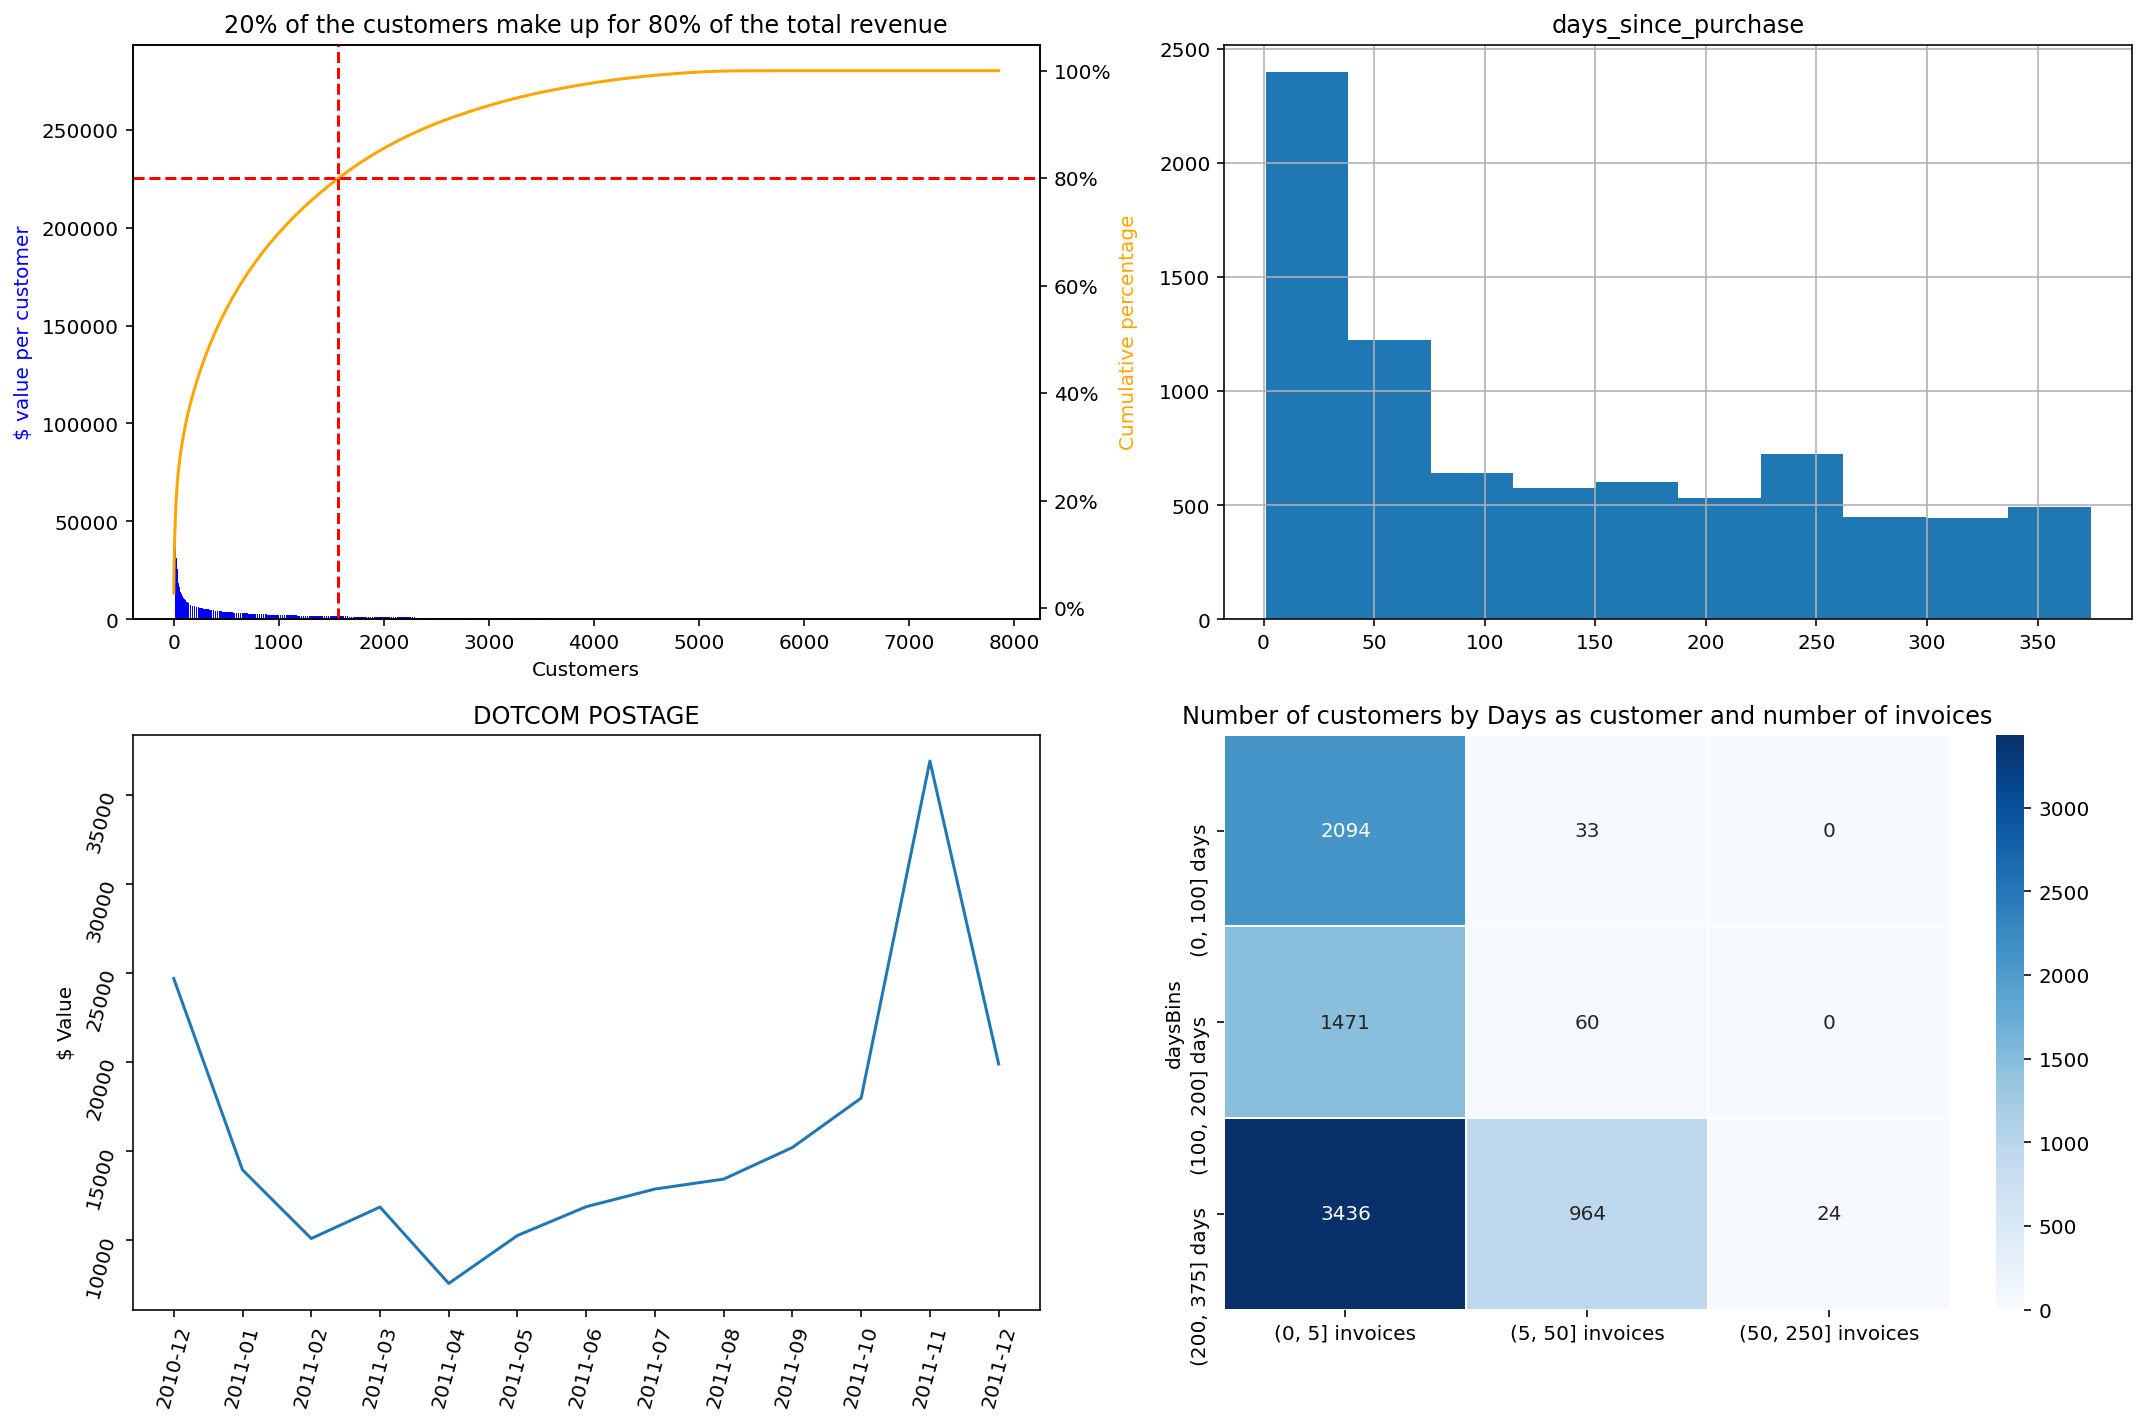

In [27]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].set_title('{}% of the customers make up for 80% of the total revenue'.format(round(value_closest_to_80/len(desc_price)*100)))

ax2 = ax[0,0].twinx()

ax[0,0].bar(desc_price.index,desc_price['TotalPrice'],color='blue');
ax[0,0].set_xlabel('Customers')
ax[0,0].set_ylabel('$ value per customer',color='blue')

ax2.plot(desc_price.index,desc_price['cumulative_pct'],color='orange');
ax2.set_ylabel('Cumulative percentage',color='orange')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.axhline(y=80, color='r', linestyle='--');
ax2.axvline(x=value_closest_to_80, color='r', linestyle='--');

## days_since_purchase
df4 = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
df4.columns = ['CustomerID', 'lastInvoice']
df4['lastDate'] = df['InvoiceDate'].max()
df4['days_since_purchase'] = 1 + (df4['lastDate']-df4['lastInvoice']).astype('timedelta64[D]')
df4 = df4.drop(['lastDate','lastInvoice'], axis=1).sort_values('days_since_purchase', ascending=False)
df4.hist(ax=ax[0,1]);

dfW = dfT[dfT['Description'] == 'DOTCOM POSTAGE']
ax[1,0].plot(dfW['month_year'],dfW['TotalPrice'],label='DOTCOM POSTAGE')
ax[1,0].tick_params(labelrotation=75)
ax[1,0].set_ylabel('$ Value')
ax[1,0].set_title('DOTCOM POSTAGE')

# df7.plot.bar(stacked=True, ax=ax[1,1])
# ax[1,1].set_xticks([x for x in range(len(df7['countBins']))])
# ax[1,1].set_xticklabels(df7['countBins'])

# ax[1,1].set_title("Number of invoices by total spending per customer:")
# ax[1,1].set_xlabel('Number of invoices per customer')
# ax[1,1].set_ylabel('Number of customers');

# df3 = df3.set_index('daysBins')
sns.heatmap(df3, cmap='Blues', linewidths=0.5, annot=True,fmt='g',ax=ax[1,1]); #cmap='RdYlGn_r'
ax[1,1].set_title('Number of customers by Days as customer and number of invoices');



plt.tight_layout()
plt.savefig('Customers Insights & RFM Analysis.png', dpi=500,transparent=False)
plt.show()